In [1]:
from pathlib import Path
import gzip
import json
import requests
from requests.auth import HTTPBasicAuth
import urllib3

import numpy as np
import pandas as pd
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import datamine.io as dm

In [2]:
path = Path("/media/hemu/Data/Markets/Crypto/CME/CRYPTOCURRENCY")

files = list(path.iterdir())
files.sort()
print(*files[:5], sep='\n')
# df = pd.read_json(files[0])

/media/hemu/Data/Markets/Crypto/CME/CRYPTOCURRENCY/20170407_btcIndexJson.gz
/media/hemu/Data/Markets/Crypto/CME/CRYPTOCURRENCY/20170408_btcIndexJson.gz
/media/hemu/Data/Markets/Crypto/CME/CRYPTOCURRENCY/20170409_btcIndexJson.gz
/media/hemu/Data/Markets/Crypto/CME/CRYPTOCURRENCY/20170410_btcIndexJson.gz
/media/hemu/Data/Markets/Crypto/CME/CRYPTOCURRENCY/20170411_btcIndexJson.gz


In [3]:
# pd.read_json(files[0], )

In [4]:
url = 
resp = requests.post()

SyntaxError: invalid syntax (<ipython-input-4-5b1ff00ae95c>, line 1)

In [5]:
myDatamine = dm.DatamineCon(username='hanwant', password='Yamankalyan1', path='/media/hemu/Data/Markets/Crypto/CME/')

In [6]:
myDatamine.get_catalog()
print(myDatamine.data_catalog)

get_catalog: retrieving all datasets, limit None


KeyError: 'files'

In [9]:
# dat = myDatamine.load_dataset("CRYPTOCURRENCY", download=True, limit=10, dataset_args={"yyyymmdd": 20200101})
# myDatamine.crypto_load()

In [25]:
myDatamine.download_file("20210109-CRYPTOCURRENCY")

RequestError: FID not found in the catalog: 20210109-CRYPTOCURRENCY

In [26]:
DTYPES = {'category': ('mdEntryCode', 'mdEntryType', 'mdUpdateAction',
                       'symbol', 'openCloseSettlFlag'),
          'int64': ('rptSeq',),
          'float': ('netChgPrevDay', 'netPctChg', 'mdEntryPx'),
          'date:%Y%m%d_%H:%M:%S.%f': 'mdEntryDateTime'}

def read_raw_df(filename):
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        result = []
        for line in f:
            line = json.loads(line)
            if 'mdEntries' in line:
                result.append(line['mdEntries'][0])
        result = pd.DataFrame(result)
        result['mdEntryDateTime'] = result['mdEntryDate'] + '_' + result['mdEntryTime']
        result = result.drop(['mdEntryDate', 'mdEntryTime'], axis=1)
    return result
    
def process_raw_df(df, dtypes):
    for dtype, cols in dtypes.items():
        for col in ((cols,) if isinstance(cols, str) else cols):
            if col in df:
                if dtype.startswith('date'):
                    format = None if dtype == 'date' else dtype[5:]
                    df[col] = pd.to_datetime(df[col], format=format, utc=True, errors='ignore')
                else:
                    df[col] = df[col].astype(dtype, errors='ignore')
    return df

def load_df(filename, dtypes):
    df = read_raw_df(filename)
    df = process_raw_df(df, dtypes)
    return df

def partition_df(df):
    dfs={}
    symbols = df['symbol'].unique()
    for symbol in symbols:
        dfs[symbol] = df[df['symbol']==symbol]
    return dfs

def bounds_ok(df, hd_filename, key):
    """ 
    Checks that df mdEntryDateTIme is AFTER whats already saved in hdf file.
    Assumes df is in cme format and hd file contains key 'timestamps' 
    """
    if hd_filename.is_file():
#         start = pd.read_hdf(hd_filename, key=key, start=0, stop=1)['timestamps'].iloc[0]
#         df_end = df['mdEntryDatetime'].iloc[-1].value
        with pd.HDFStore(hd_filename, mode='r') as f:
            keys = f.keys()
        if key in keys:
            df_start = df['mdEntryDateTime'].iloc[0].value
            end = pd.read_hdf(hd_filename, key=key, start=-2, stop=-1)['timestamps'].iloc[0]
            if not (df_start > end ):
                return False
    return True

def save_to_hdf(df, hd_filename, key):
    if not bounds_ok(df, hd_filename, key):
        raise IndexError("Overlapped index", df['mdEntryTime'].iloc[0])
    _df = pd.DataFrame({'timestamps': df['mdEntryDateTime'].astype(int),
                       'price': df['mdEntryPx']})
    _df.to_hdf(hd_filename, key=key, mode='a', append=True, format='table')
    
def save_partitions_to_hdf(dfs, hd_filename, key):
    for name, df in dfs.items():
        save_to_hdf(df, hd_filename, key+'/'+name)
    
def load_from_hdf(hd_filename, key, start=None, stop=None):
    df = pd.read_hdf(hd_filename, key=key, start=start, stop=stop)
    df['timestamps'] = pd.to_datetime(df['timestamps'])
    return df
    
def cme_format_to_hdf(cme_filename, hd_filename, key):
    dfs = partition_df(load_df(cme_filename, DTYPES))
    save_partitions_to_hdf(dfs, hd_filename, key)

In [27]:
def convert_all_to_hdf(files, hd_filename, key):
    for file in tqdm(files):
        cme_format_to_hdf(file, hd_filename, key)
            

In [ ]:
def resample_hdf

In [59]:
files[989]

PosixPath('/media/hemu/Data/Markets/Crypto/CME/CRYPTOCURRENCY/20191225_btcIndexJson.gz')

In [60]:
load_df(files[989], DTYPES)

,symbol,rptSeq,mdEntryType,mdEntryPx,mdUpdateAction,openCloseSettlFlag,netChgPrevDay,netPctChg,mdEntryCode,mdEntryDateTime
0,ETHUSD_RTI,52626143,INDEX_VALUE,127.59,NEW,NaN,NaN,NaN,NaN,2019-12-25 00:00:00+00:00
1,BRTI,101932508,INDEX_VALUE,7251.96,NEW,NaN,NaN,NaN,NaN,2019-12-25 00:00:00+00:00
2,BRTI,101932509,INDEX_VALUE,7251.94,NEW,NaN,NaN,NaN,NaN,2019-12-25 00:00:01+00:00
3,ETHUSD_RTI,52626144,INDEX_VALUE,127.59,NEW,NaN,NaN,NaN,NaN,2019-12-25 00:00:01+00:00
4,BRTI,101932510,INDEX_VALUE,7251.76,NEW,NaN,NaN,NaN,NaN,2019-12-25 00:00:02+00:00
...,...,...,...,...,...,...,...,...,...,...
172797,ETHUSD_RTI,52712540,INDEX_VALUE,124.80,NEW,NaN,NaN,NaN,NaN,2019-12-25 23:59:57+00:00
172798,BRTI,102018906,INDEX_VALUE,7194.50,NEW,NaN,NaN,NaN,NaN,2019-12-25 23:59:58+00:00
172799,ETHUSD_RTI,52712541,INDEX_VALUE,124.80,NEW,NaN,NaN,NaN,NaN,2019-12-25 23:59:58+00:00
172800,BRTI,102018907,INDEX_VALUE,7194.57,NEW,NaN,NaN,NaN,NaN,2019-12-25 23:59:59+00:00


In [10]:
savepath = Path("/media/hemu/Data/Markets/Crypto/CME/crypto.hdf5")

In [50]:
# Test single file
# cme_format_to_hdf(files[0], savepath, 'min')

In [51]:
files = list(path.iterdir())
files.sort()
done = 0

1021

In [62]:
convert_all_to_hdf(files[990:], savepath, 'sec')

In [45]:
with pd.HDFStore(savepath, mode='r') as f:
    print(f.keys())

['/min/BRR', '/min/BRTI']


In [44]:
df = load_from_hdf(savepath, 'sec/BRTI', start = -1, stop = None)
df.reset_index(drop=True)

,timestamps,price
0,2017-05-26 23:59:59,2250.54


In [63]:
df = load_from_hdf(savepath, 'sec/BRTI')
df

,timestamps,price
0,2017-04-07 00:00:00,1190.52
1,2017-04-07 00:00:01,1190.52
2,2017-04-07 00:00:02,1190.60
3,2017-04-07 00:00:03,1190.53
4,2017-04-07 00:00:04,1190.55
...,...,...
172790,2020-03-15 23:59:54,5342.32
172793,2020-03-15 23:59:55,5342.81
172795,2020-03-15 23:59:56,5344.05
172797,2020-03-15 23:59:57,5344.36


In [65]:
df = df.set_index('timestamps')


In [66]:
df_min = df.resample('1min')
del df

In [68]:
df_min.ohlc()

# Preprocess

In [3]:
import rollers

In [4]:
rollers.Roller

rollers.Roller

In [6]:
def create_datasets(f, group_name, asset_name, nfeats=49+1):
    """
    f: file handle - I.e passed from within context manager
    Create group and datasets for feature matrix
    and timestamps - both resizable.
    """
    if group_name not in f.keys():
        f.create_group(group_name)
    group = f[group_name]
    if 'assets' not in group.attrs.keys():
        group.attrs.create('assets', data=np.array([asset_name]), 
                           dtype=h5py.string_dtype(encoding='utf-8'))
    if 'price' not in group.keys():
        group.create_dataset('price', shape=(0,), dtype=np.float64,
                             maxshape=(None,))
    if 'features' not in group.keys():
        group.create_dataset('features', shape=(0, nfeats), dtype=np.float64,
                             maxshape=(None, nfeats))
    if 'timestamps' not in group.keys():
        group.create_dataset('timestamps', shape=(0, ), dtype=np.int64,
                             maxshape=(None, ))

def post_process(close, processed):
    """ 
    Transformations:
    - scale sd and volatility by dividing by close price
    - log(all features which are derived from and same scale as price)
      - open, high , low, mean, close
    - remove raw returns - keep log returns
    - flatten features
    - add close price to flattened feats
    """
    processed[:, 6:, :] /= close[:, None, None]
    processed[:, 0, :] = np.log(processed[:, 0, :])
    processed[:, 1, :] = np.log(processed[:, 1, :])
    processed[:, 2, :] = np.log(processed[:, 2, :])
    processed[:, 3, :] = np.log(processed[:, 3, :])
    processed = np.delete(processed, 4, 1) 
    processed = np.concatenate([np.log(close)[:, None], 
                                processed.reshape(processed.shape[0], -1)
                               ], axis=1)
    return processed

def resample(close, processed, timestamps, timeframe):
    """ Levarages pandas to resample (using close/last as aggregation method)"""
    pdf = pd.DataFrame(processed)
    pdf['close'] = close
    pdf = pdf.set_index((timestamps).view('datetime64[ns]'))
    pdf = pdf.resample(timeframe).last().dropna()
    return pdf['close'].values, pdf.drop('close', axis=1).values, pdf.index.values.view(np.int64)

def save_processed_to_hdf(price, processed, timestamps, hd_filename, 
                          group_name, asset_name):
    """ Appends to existing datasets """
    with h5py.File(hd_filename, mode='a') as f:
        # create_datasets does nothing if datasets already exist
        # convenient as it uses nfeats from proceesed.shape the first time
        create_datasets(f, group_name, asset_name, nfeats=processed.shape[1])
        grp = f[group_name]
        price_dset = grp['price']
        feats_dset = grp['features']
        timestamps_dset = grp['timestamps']
        curr_len = price_dset.shape[0]
        assert curr_len == feats_dset.shape[0] == timestamps_dset.shape[0]
        assert price.shape[0] == processed.shape[0] == timestamps.shape[0]
        new_len = curr_len + price.shape[0]
        price_dset.resize((new_len, ))
        feats_dset.resize((new_len, feats_dset.shape[1]))
        timestamps_dset.resize((new_len, ))
        price_dset[curr_len: new_len] = price
        feats_dset[curr_len: new_len] = processed
        timestamps_dset[curr_len: new_len] = timestamps
        
def process_full(raw_datapath, raw_key, processed_savepath, processed_key,
                 asset_name, timeframes, resample_timeframe = None, chunksize=1000000):
    roller = rollers.Roller(timeframes)
    streamer = pd.read_hdf(raw_datapath, key=raw_key, iterator=True,
                          chunksize=chunksize)
    full_len = streamer.stop
    streamer = iter(streamer)
    tq = tqdm(total=full_len)
    for chunk in streamer:
        price = chunk['price'].values
        timestamps = chunk['timestamps'].values.astype(np.uint64)
        processed = roller.roll(price, timestamps)
        processed = post_process(price, processed)
        if resample_timeframe is not None:
            price, processed, timestamps = resample(price, processed, timestamps, 
                                                    resample_timeframe)
        save_processed_to_hdf(price, processed, timestamps, processed_savepath, 
                              processed_key, asset_name)
        tq.update(chunksize)

In [7]:
raw_datapath = Path("/media/hemu/Data/Markets/Crypto/CME/crypto.hdf5")
raw_key = 'sec/BRTI'
processed_savepath = Path("/media/hemu/Data/Markets/Crypto/CME/brti_rolled.hdf5")
processed_key = '5min'
resample_timeframe = '5min'
timeframes = ['1min', '1h', '2h', '4h', '8h', '1day', '7day']
asset_name = "BRTI"


In [7]:
process_full(raw_datapath, raw_key, processed_savepath, processed_key, asset_name,
            timeframes, resample_timeframe = resample_timeframe, chunksize=1000000)

In [32]:
def delete_key(filepath, key):
    with h5py.File(filepath, 'a') as f:
        if key in f.keys():
            del f[key]

In [11]:
## CHECK
processed_key = "15min"
with h5py.File(processed_savepath, 'a') as f:
    grp = f[processed_key]
    if 'assets' not in grp.attrs.keys():
        grp.attrs.create('assets', data=np.array(['BRTI']), dtype=h5py.string_dtype(encoding='utf-8'))
    
with h5py.File(processed_savepath, 'r') as f:
    grp = f[processed_key]
    print(grp.attrs['assets'])
    print(grp.keys())
    print(grp['price'].dtype)
    print(grp['features'].dtype)
    print(grp['timestamps'].dtype)
    print(grp['price'].shape)
    print(grp['features'].shape)
    print(grp['timestamps'].shape)
    print('time bounds: ', pd.to_datetime(grp['timestamps'][0]), pd.to_datetime(grp['timestamps'][-1]))
    price = grp['price'][:]
#     feats = grp['rolled'][:]
    timestamps = grp['timestamps'][:]
    

['BRTI']
<KeysViewHDF5 ['features', 'price', 'timestamps']>
float64
float64
int64
(102708,)
(102708, 50)
(102708,)
time bounds:  2017-04-07 00:00:00 2020-03-15 23:45:00


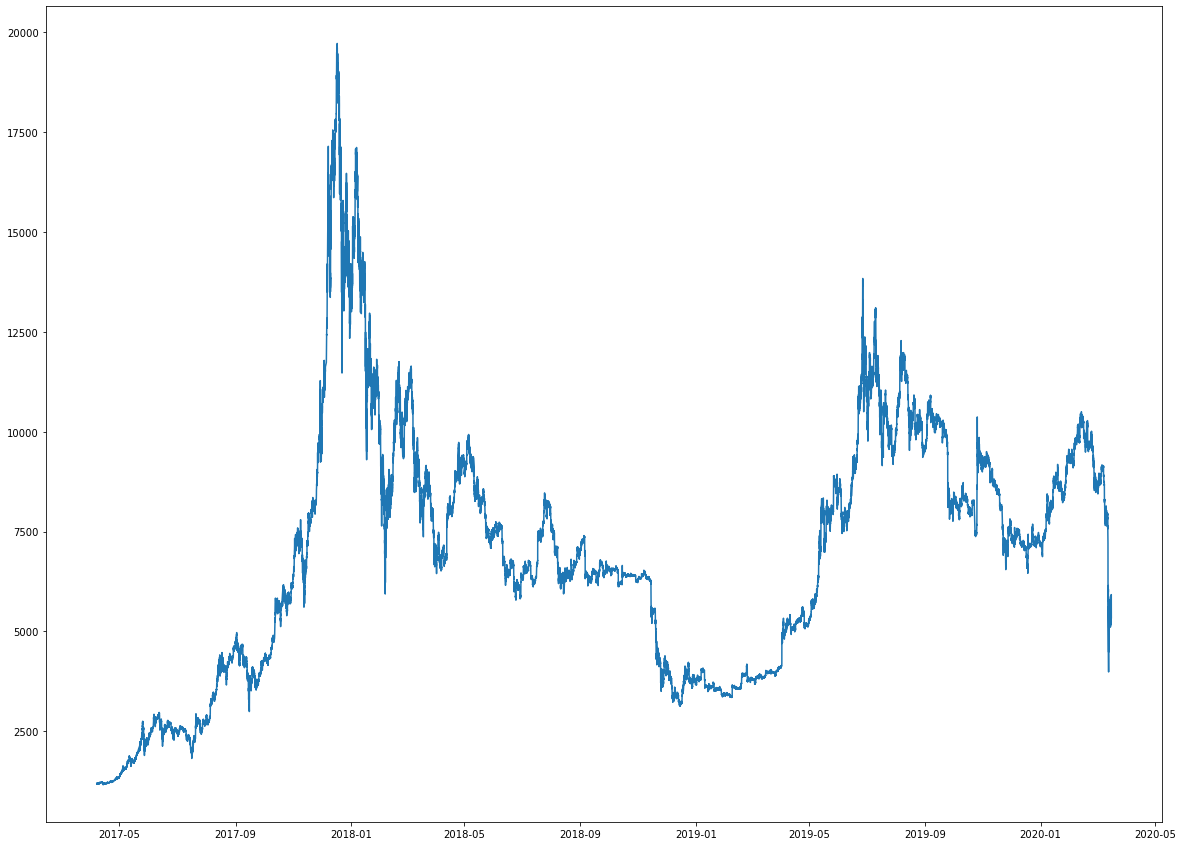

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(pd.to_datetime(timestamps), price)

## Working

['BRTI']
<KeysViewHDF5 ['features', 'price', 'timestamps']>
float64
float64
int64
(1539089,)
(1539089, 50)
(1539089,)


In [19]:
print(feats.shape, timestamps.shape)
feats[:5]

NameError: name 'feats' is not defined

In [67]:
raw_streamer = (pd.read_hdf(raw_datapath, key=raw_key, iterator=True, chunksize=1000000))
print(raw_streamer.nrows, raw_streamer.stop)
raw_streamer = iter(raw_streamer)

92688435 92688435


In [72]:
chunk = next(raw_streamer)
price = chunk['price'].values
timestamps = chunk['timestamps'].values.astype(np.uint64)
processed = roller.roll(price, timestamps=timestamps)
processed = post_process(price, processed)
# processed = transform()
# save_processed_to_hdf(processed, timestamps, processed_savepath, processed_key)


In [73]:
pdf = pd.DataFrame(processed)
pdf = pdf.set_index((timestamps).view('datetime64[ns]'))
pdf = pdf.resample('1min').last()

In [82]:
print(pdf.values.shape, pdf.index.values.shape)
print(pdf.values.dtype, pdf.index.values.dtype)
pdf.values, pdf.index.values.view(np.int64)

(16650, 50) (16650,)
float64 datetime64[ns]


(array([[7.19837055, 7.53033513, 7.52756803, ..., 0.47831546, 0.41576852,
         0.26844898],
        [7.19866962, 7.53033513, 7.52756803, ..., 0.47817089, 0.41564276,
         0.26836764],
        [7.19856496, 7.53033513, 7.52756803, ..., 0.47821941, 0.41568484,
         0.26839467],
        ...,
        [7.53035123, 7.53033513, 7.52756803, ..., 0.31023565, 0.26816009,
         0.1739154 ],
        [7.53024928, 7.53033513, 7.52756803, ..., 0.31026497, 0.26818551,
         0.17393276],
        [7.53020635, 7.53033513, 7.52756803, ..., 0.3102781 , 0.26819686,
         0.1739402 ]]),
 array([1493523180000000000, 1493523240000000000, 1493523300000000000, ...,
        1494522000000000000, 1494522060000000000, 1494522120000000000]))

In [75]:
pdf.iloc[:, -10:]

,40,41,42,43,44,45,46,47,48,49
2017-04-30 03:33:00,0.055923,0.079515,0.125759,0.480833,0.476710,0.468898,0.464118,0.478315,0.415769,0.268449
2017-04-30 03:34:00,0.055907,0.079491,0.125721,0.480688,0.476565,0.468756,0.463978,0.478171,0.415643,0.268368
2017-04-30 03:35:00,0.055914,0.079500,0.125733,0.480737,0.476614,0.468803,0.464025,0.478219,0.415685,0.268395
2017-04-30 03:36:00,0.055906,0.079488,0.125713,0.480663,0.476541,0.468732,0.463954,0.478146,0.415621,0.268353
2017-04-30 03:37:00,0.055887,0.079459,0.125667,0.480489,0.476368,0.468562,0.463786,0.477973,0.415471,0.268256
...,...,...,...,...,...,...,...,...,...,...
2017-05-11 16:58:00,0.092546,0.096788,0.105317,0.311587,0.308804,0.303486,0.300312,0.310312,0.268226,0.173956
2017-05-11 16:59:00,0.092542,0.096783,0.105310,0.311549,0.308767,0.303449,0.300276,0.310275,0.268194,0.173936
2017-05-11 17:00:00,0.092537,0.096777,0.105301,0.311510,0.308728,0.303411,0.300239,0.310236,0.268160,0.173915
2017-05-11 17:01:00,0.092553,0.096793,0.105316,0.311540,0.308757,0.303440,0.300267,0.310265,0.268186,0.173933


((16668, 50),
                           0         1         2         3         4   \
 2017-04-18 13:46:00  1208.16  7.096423  7.097772  7.096440  7.093612   
 2017-04-18 13:47:00  1207.92  7.096937  7.097326  7.096730  7.093928   
 2017-04-18 13:48:00  1207.86  7.096705  7.098351  7.096307  7.093778   
 2017-04-18 13:49:00  1208.00  7.096307  7.098194  7.095976  7.093529   
 2017-04-18 13:50:00  1207.80  7.096622  7.098037  7.096738  7.093172   
 ...                      ...       ...       ...       ...       ...   
 2017-04-30 03:29:00  1337.71  7.198909  7.200485  7.200485  7.205806   
 2017-04-30 03:30:00  1337.92  7.198677  7.200649  7.200805  7.205784   
 2017-04-30 03:31:00  1336.74  7.198827  7.200358  7.201387  7.205761   
 2017-04-30 03:32:00  1337.29  7.198109  7.199731  7.200917  7.205962   
 2017-04-30 03:33:00  1337.59  7.198460  7.200253  7.201119  7.205680   
 
                            5         6         7         8         9   ...  \
 2017-04-18 13:46:00  7.10953

In [100]:
with h5py.File(processed_savepath, 'r') as f:
    grp = f[processed_key]
    print(grp['rolled'].shape)
    print(grp['timestamps'].shape)

(1000000, 50)
(1000000,)


In [123]:
def test():
    for i in range(10):
        yield i
        
it = iter(test())
for i in tqdm(it, total=10):
    print(i)


0
1
2
3
4
5
6
7
8
9



# Raw API Calls

In [14]:
base_url = 'https://datamine.cmegroup.com/cme/api/v1'
dataset='CRYPTOCURRENCY'
file = "20210109-CRYPTOCURRENCY"
url = f"{base_url}/list?dataset={dataset}"

# url = f"{base_url}/list?fid={file}"
user="hanwant"
# user="API_HEMU_CRYPTO_2021"
password="Yamankalyan1"
params = {
#     "user": f"{user}:{password}"
#     "user": user,
#     "password": password,
    "fid": file
}
url = 'https://datamine.cmegroup.com/cme/api/v1/list'
auth = HTTPBasicAuth(user, password)

In [15]:
session = requests.Session()
session.auth = auth
retry = urllib3.util.Retry(read=3, backoff_factor=2, status_forcelist=[400])
adapter = requests.adapters.HTTPAdapter(max_retries=retry)
session.mount('', adapter)

In [23]:
resp = session.get(url, params=params, verify=True)


/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datamine.cmegroup.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [21]:
resp = requests.get(url, data=None, auth = auth)

In [24]:
# resp = requests.get(url, params = {"fid": file}, auth=auth)
print(resp.text)
print(resp.json())

{"error":"unauthorized","error_description":"Full authentication is required to access this resource"}
{'error': 'unauthorized', 'error_description': 'Full authentication is required to access this resource'}


In [57]:
import logging
logging.getLogger().setLevel(logging.DEBUG)